## K Nearest Neighbors

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [22]:
filename = input('Enter the name of the Training File: ')
train = pd.read_csv(filename, sep = '\t', skiprows=1, names = ['Test1', 'Test2', 'Value','Random'])
train = train[['Test1', 'Test2', 'Value']]

In [23]:
filename = input('Enter the name of the Testing File: ')
test = pd.read_csv(filename, sep = '\t', skiprows=1, names = ['Test1', 'Test2', 'Value','Random'])
test = test[['Test1', 'Test2', 'Value']]

In [24]:
temp = pd.DataFrame()
temp = temp.append(train)
temp = temp.append(test)

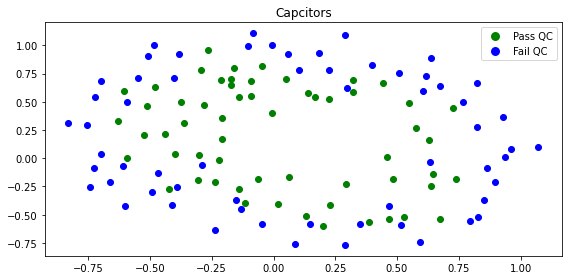

In [25]:
fig, ax = plt.subplots(figsize=(8,4))

ax.scatter(temp[temp['Value'] == 1.0].iloc[:,0], temp[temp['Value'] == 1.0].iloc[:,1], color='green')
ax.scatter(temp[temp['Value'] == 0.0].iloc[:,0], temp[temp['Value'] == 0.0].iloc[:,1], color='blue')
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='g', label='Pass QC', markersize=10),
           Line2D([0], [0], marker='o', color='w', markerfacecolor='b', label='Fail QC', markersize=10)]
plt.legend(handles=legend_elements)
plt.title('Capcitors')
fig.tight_layout()

In [26]:
def eucledian_distance(p, q):
    return np.sqrt((p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2)

In [27]:
def KNearestNeighbors(train, test, k):
    result = []
    for test_index, test_row in test.iterrows():
        p = (test_row['Test1'], test_row['Test2'])
        ind = 0 #Ensures 2 same points at the same distance are recognised too
        distances = {}
        for train_index, train_row in train.iterrows():
            q = (train_row['Test1'], train_row['Test2'])
            distances[(ind, q, train_row['Value'])] = eucledian_distance(p, q)
            ind+=1
        temp = sorted(distances.items(), key=lambda x: x[1])[0:k]

        nearest_neighbor = {}
        for i in temp:
            if i[0][2] in nearest_neighbor:
                nearest_neighbor[i[0][2]] +=1
            else:
                nearest_neighbor[i[0][2]] = 1
        result.append(max(nearest_neighbor.items(), key=lambda x: x[1])[0])
    return result

In [28]:
def Kfold(train):
    end = 0
    kfold = 1
    k = list(range(1, 24, 2))
    final_result = pd.DataFrame(columns = k)
    while end < len(train):
        start = end
        end += 17
        k_test = train.iloc[start:end, : ]
        train_1 = train.iloc[:start, : ]
        train_2 = train.iloc[end:, : ]
        k_train = pd.DataFrame()
        k_train = k_train.append(train_1)
        k_train = k_train.append(train_2)

        for i in k:
            result = KNearestNeighbors(k_train, k_test, i)
            k_test['Predicted'] = result
            misclassify = len(k_test[k_test['Value'] != k_test['Predicted']])
            final_result.loc['Val_'+ str(kfold) +'_Errors', i] = misclassify
        
        kfold += 1
    
    return final_result

In [29]:
res = Kfold(train)

<ipython-input-28-21d42e4251c4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_test['Predicted'] = result


In [30]:
res.loc['Total_Errors'] = res.sum(axis = 0)

In [31]:
res

,1,3,5,7,9,11,13,15,17,19,21,23
Val_1_Errors,8,6,4,4,5,5,6,7,6,6,8,8
Val_2_Errors,7,2,3,3,3,3,3,5,7,7,7,6
Val_3_Errors,7,3,3,4,4,7,5,5,7,8,7,8
Val_4_Errors,9,6,3,2,5,5,6,6,8,7,11,11
Val_5_Errors,8,5,8,10,10,9,7,7,8,9,10,11
Total_Errors,39,22,21,23,27,29,27,30,36,37,43,44


In [32]:
x = list(res.columns)
y = (1 - (res.loc['Total_Errors'] / 85)) * 100

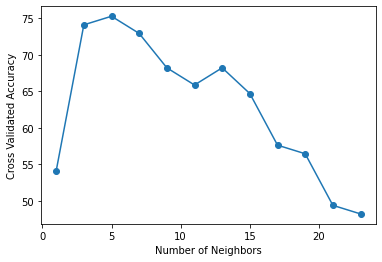

In [33]:
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross Validated Accuracy')
plt.plot(x, y, marker = 'o')

In [34]:
test['Predicted'] = KNearestNeighbors(train, test, k = 5)

In [35]:
tp = len(test[(test['Predicted'] == 1) & (test['Value'] == 1)])
tn = len(test[(test['Predicted'] == 0) & (test['Value'] == 0)])
fp = len(test[(test['Predicted'] == 1) & (test['Value'] == 0)])
fn = len(test[(test['Predicted'] == 0) & (test['Value'] == 1)])

In [36]:
confusion_matrix = pd.DataFrame(columns = ['Actual 1', 'Actual 0'])

In [37]:
confusion_matrix.loc['Predicted 1', 'Actual 1'] = len(test[(test['Predicted'] == 1) & (test['Value'] == 1)])
confusion_matrix.loc['Predicted 0', 'Actual 0'] = len(test[(test['Predicted'] == 0) & (test['Value'] == 0)])
confusion_matrix.loc['Predicted 1', 'Actual 0'] = len(test[(test['Predicted'] == 1) & (test['Value'] == 0)])
confusion_matrix.loc['Predicted 0', 'Actual 1'] = len(test[(test['Predicted'] == 0) & (test['Value'] == 1)])

In [38]:
confusion_matrix

,Actual 1,Actual 0
Predicted 1,10,6
Predicted 0,7,10


In [39]:
accuracy = (tp + tn) / (tp+fp+tn+fn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
temp = (1/recall) + (1/precision)
f1_score = 2 * (1 / temp)

In [42]:
print("Accuracy:",round(accuracy, 2))
print("Precision:",round(precision, 2))
print("Recall:",round(recall, 2))
print("f1_score:",round(f1_score, 2))

Accuracy: 0.61
Precision: 0.62
Recall: 0.59
f1_score: 0.61
